Eq(f(x), C1*exp(-0.196*x) + 50.0)

50.0 - exp(-0.196*x)

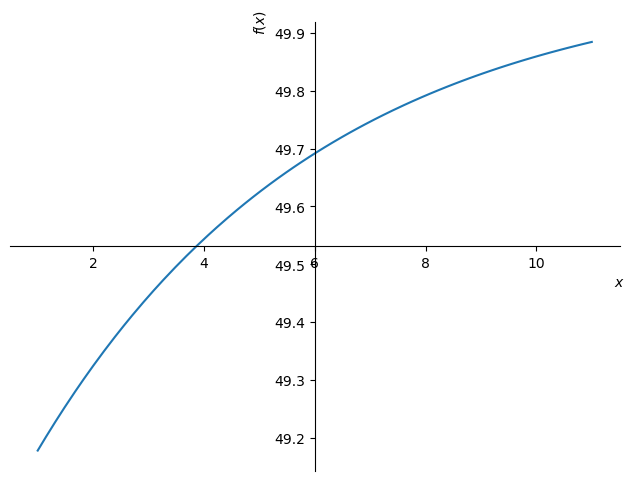

49.1779877653218


In [2]:
import numpy as np
import sympy as sp
from sympy import Function, dsolve, Eq, Derivative, sin, cos, symbols, Symbol,lambdify
from sympy.abc import x
f = Function('f')

# eq = sin(x)*cos(f(x)) + cos(x)*sin(f(x))*f(x).diff(x)
# dsolve(eq, hint='1st_exact')

#using examples on https://tutorial.math.lamar.edu/classes/de/linear.aspx

MIN_X = 1.0
MAX_X = 11.0

f = Function('f')
fprime = 9.8 - 0.196*f(x)
#fprime = f(x) + 2*x
#eq = f(x).diff(x) - f(x)/x - 2*x
eq = f(x).diff(x) - fprime 
solution = dsolve(eq) #, hint='1st_exact')
display(solution)
finite_solution = solution.subs(Symbol('C1'), -1).rhs
display(sp.expand(finite_solution))
sp.plot(finite_solution, (x, MIN_X, MAX_X))
y1 = finite_solution.subs({x:MIN_X})
print(y1)

/home/mcwave/anaconda3/envs/torch200/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:251: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)


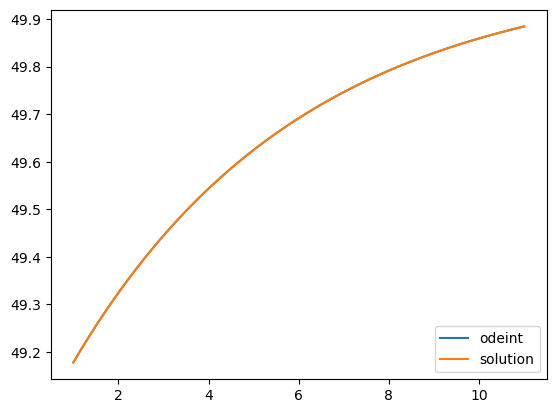

In [5]:
from tqdm import tqdm
from scipy.integrate import odeint

DELTA = 0.001
NUM_POINTS = 10000

fprime_l = lambdify((x, f(x)), fprime, "numpy")

def derivative_func(y,t):
    return fprime_l(np.array([t]), np.array([y]))[0]

# time points
xs = np.arange(MIN_X, MAX_X, 0.001)

# initial condition
# y0 = 1.0

# solve ODE
ys = odeint(derivative_func,y1,xs, printmessg=True)
ys = ys.flatten()

# cur = (1.0, 1.0)
# xs = [cur[0]]
# ys = [cur[1]]
# #fprime.subs({x:cur[0], f(x):cur[1]})

# pbar = tqdm(total=NUM_POINTS/10)

# for i in range(NUM_POINTS-1):
#     if i % 10 == 0:
#         pbar.update(1)
#     slope = fprime.subs({x:cur[0], f(x):cur[1]})
#     cur = (cur[0]+DELTA, cur[1]+DELTA*slope)
#     xs.append(cur[0])
#     ys.append(cur[1])

# xs = np.array(xs)
# ys = np.array(ys)

finite_solution_l = lambdify((x), finite_solution, "numpy")
actual_ys = finite_solution_l(xs)

from matplotlib import pyplot as plt
plt.plot(xs, ys, label='odeint')
plt.plot(xs, actual_ys, label='solution')
plt.legend(["odeint", "solution"], loc ="lower right") 
#plt.plot(xs, actual_ys-ys)
plt.show()

In [8]:
# Load symbolicregression model

import torch
import os, sys
import symbolicregression
from symbolicregression import model as symbolicregression_model
import sympytorch
import requests

model_path = "ckpt/model.pt" 
try:
    if not os.path.isfile(model_path): 
        print("Downloading model...")
        url = "https://dl.fbaipublicfiles.com/symbolicregression/model1.pt"
        r = requests.get(url, allow_redirects=True)
        open(model_path, 'wb').write(r.content)
    if not torch.cuda.is_available():
        model = torch.load(model_path, map_location=torch.device('cpu'))
    else:
        model = torch.load(model_path)
        model = model.cuda()
    print(model.device)
    print("Model successfully loaded!")

except Exception as e:
    print("ERROR: model not loaded! path was: {}".format(model_path))
    print(e)    
    
est = symbolicregression_model.SymbolicTransformerRegressor(
                        model=model,
                        max_input_points=10001,
                        n_trees_to_refine=5,
                        rescale=True
                        )
##Example of data
xs = np.reshape(xs, (len(xs),1))
ys = np.reshape(ys, (len(xs),1))
est.fit(xs,ys)

replace_ops = {"add": "+", "mul": "*", "sub": "-", "pow": "**", "inv": "1/"}
model_str = est.retrieve_tree(with_infos=True)["relabed_predicted_tree"].infix()
for op,replace_op in replace_ops.items():
    model_str = model_str.replace(op,replace_op)

expr = sp.parse_expr(model_str)
display(expr)

expr=sp.expand(expr)
display(expr)

cuda:0
Model successfully loaded!


/home/mcwave/anaconda3/envs/torch200/lib/python3.10/site-packages/torch/_functorch/deprecated.py:65: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.grad instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('grad')


50.016934784119414 - 1.0161284002162041*exp(-0.19166387817875827*x_0)

50.016934784119414 - 1.0161284002162041*exp(-0.19166387817875827*x_0)

In [ ]:
# import math
# CONSTANTS = {"pi":3.14159, "e":2.71828}

# # Infer the complexity of an expression
# # complexity is defined as follows:
# #   A constant's complexity is log2(constant)
# #   Otherwise it is the number of operators plus sum of all constants' complexities
# # Params:
# #   expr is a sympy expression
# # Returns:
# #   complexity (float)
# def complexity(expr):
#     # Case 1: Is numeric
#     if expr.is_constant():
#         return math.log2(math.abs(expr.evalf()))
#     # Case 2: Otherwise
#     num_ops = sp.count_ops(sp.sympify(expr))
#     constants = [t for t in expr.atoms() if t not in expr.free_symbols]
#     result = num_ops
#     for constant in constants:
#         result += math.log2(math.abs(constant.evalf()))
#     return result

# def approximate_number(target, max_relative_diff=0.1):
#     candidates = []
#     if math.abs(target) >= 1 - max_relative_diff:
#         diff = math.abs(target, round(target))/math.abs(target)
#         if diff < max_relative_diff:
#             expr = sympify(str(round(target)))
#             candidates.append((expr, complexity(expr), diff))
#     else:
        

# # Find the best way to convert the target number into
# # a succint expression.
# # Params:
# #   target: The target number
# #   coefs: The existing coefficients, such as {"a": 1.96}
# #   max_relative_diff: The maximum diff allowed (relative)
# # Returns:
# #   (sympy expression, complexity, diff)
# def normalize_coefficient(target, coefs, max_relative_diff=0.1):
#     all_coefs = dict(coefs.items())
#     all_coefs.update(CONSTANTS)
#     coefs = all_coefs
#     candidates = [] # expression, complexity, diff
#     # Try approximate target with a close number
    
#     # Try each coefficient
#     for coef,v in coefs.items():
#         # Multiplication
#         k = target / 
#         # Addition
        

In [13]:
sp.count_ops(sp.sympify("2*a+3*b"))

expr = sp.sympify("2*a+3*b")
constants = [t for t in expr.atoms() if t not in expr.free_symbols]
type(constants[0])

sympy.core.numbers.Integer